In [7]:
!pip install wbdata

  Using cached wbdata-1.1.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached dateparser-1.3.0-py3-none-any.whl.metadata (30 kB)
  Using cached shelved_cache-0.3.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached tzlocal-5.3.1-py3-none-any.whl.metadata (7.6 kB)
Using cached wbdata-1.1.0-py3-none-any.whl (18 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached cachetools-5.5.2-py3-none-any.whl (10 kB)
Using cached dateparser-1.3.0-py3-none-any.whl (318 kB)
Using cached shelved_cache-0.3.1-py3-none-any.whl (7.8 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Using cached tzlocal-5.3.1-py3-none-any.whl (18 kB)
  Attempting uninstall: cachetools
    Found existing installation: cachetools 6.2.1
    Uninstalling cachetools-6.2.1:
      Successfully uninstalled cach

In [10]:
import os, sys
print("Current folder:", os.getcwd())
sys.path.insert(0, os.path.abspath(".."))
print("Project root added:", os.path.abspath(".."))

Current folder: /home/jovyan/EEP-153---Project-1/notebooks
Project root added: /home/jovyan/EEP-153---Project-1


In [11]:
import logging
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)

In [12]:
from src.indicators import INDICATORS
from src.wb_fetch import fetch_wb_data
from src.panel import build_panel

In [14]:
import wbdata
import pandas as pd
countries_list = wbdata.get_countries()
countries_df = pd.DataFrame(countries_list)
countries_df.columns

Index(['id', 'iso2Code', 'name', 'region', 'adminregion', 'incomeLevel',
       'lendingType', 'capitalCity', 'longitude', 'latitude'],
      dtype='object')

In [15]:
def region_value(x):
    if isinstance(x, dict):
        return x.get("value")
    return x
countries_df["region_value"] = countries_df["region"].apply(region_value)
countries_only = countries_df[countries_df["region_value"] != "Aggregates"].copy()
country_codes = countries_only["id"].tolist()
len(country_codes), countries_only[["id","name","region_value"]].head()

(217,
     id         name                                       region_value
 0  ABW        Aruba                         Latin America & Caribbean 
 2  AFG  Afghanistan  Middle East, North Africa, Afghanistan & Pakistan
 5  AGO       Angola                                Sub-Saharan Africa 
 6  ALB      Albania                              Europe & Central Asia
 7  AND      Andorra                              Europe & Central Asia)

In [16]:
df_countries = fetch_wb_data(
    INDICATORS,
    start_year=2000,
    end_year=2022,
    countries=country_codes,
    cache_path="../data/wb_cache_countries.csv")
df_countries.shape, df_countries["country"].nunique(), df_countries["country"].head(10)

((4991, 6),
 217,
 0    Aruba
 1    Aruba
 2    Aruba
 3    Aruba
 4    Aruba
 5    Aruba
 6    Aruba
 7    Aruba
 8    Aruba
 9    Aruba
 Name: country, dtype: object)

In [35]:
df = fetch_wb_data(
    INDICATORS,
    start_year=2000,
    end_year=2022,
    cache_path="../data/wb_cache_countries.csv"
)

key_cols = ["ag_export_share", "food_prod_index", "adult_mortality_male", "adult_mortality_female"]

panel = build_panel(df)
panel = panel[panel["country"].isin(panel.dropna(subset=key_cols).groupby("country")["year"].nunique().loc[lambda s: s >= 15].index)]


valid_rows = panel.dropna(subset=key_cols).copy()

complete_country = valid_rows.groupby("country")[key_cols].apply(lambda g: g.notna().all().all())
complete_countries = complete_country[complete_country].index
panel_complete = valid_rows[valid_rows["country"].isin(complete_countries)].copy()

country_summary = (panel_complete.groupby("country")
                   .agg(avg_ag_export_share=("ag_export_share","mean"),
                        avg_food_prod_index=("food_prod_index","mean"),
                        avg_mort_male=("adult_mortality_male","mean"),
                        avg_mort_female=("adult_mortality_female","mean"),
                        n_years=("year","nunique"))
                   .sort_values("avg_ag_export_share", ascending=False)
                   .head(20)
                   .reset_index())

country_summary



,country,avg_ag_export_share,avg_food_prod_index,avg_mort_male,avg_mort_female,n_years
0,Solomon Islands,59.326758,108.984706,219.186000,161.175588,17
1,Benin,54.670174,86.657826,292.027478,256.566304,23
2,Central African Republic,31.707963,91.843478,595.247304,491.801304,23
3,Burkina Faso,30.838805,84.365455,324.154045,255.427000,22
4,Cameroon,18.283218,80.301739,337.946913,285.580913,23
5,Mali,16.054720,85.315263,302.738211,263.131632,19
6,Latvia,14.970820,83.869130,271.879391,101.451261,23
7,Kenya,12.122866,91.132500,382.198100,330.677550,20
8,New Zealand,11.596622,89.509545,86.807045,56.407136,22
9,Uruguay,11.504797,86.450000,157.035565,83.651609,23


In [44]:
panel = build_panel(df)

key_cols = ["ag_export_share", "food_prod_index", "adult_mortality_male", "adult_mortality_female"]
min_years = 15

print("Rows, cols:", panel.shape)
print("Countries:", panel["country"].nunique())
print("Years:", int(panel["year"].min()), "to", int(panel["year"].max()))

valid = panel.dropna(subset=key_cols).copy()

good_countries = country_years[country_years >= min_years].index
panel15 = valid[valid["country"].isin(good_countries)].copy()

print(f"\nCountries kept with >= {min_years} usable years:", panel15["country"].nunique())
print("Rows kept:", panel15.shape[0])

print("\nTop 20 country-year observations by ag_export_share (clean + >=15 years):")
display(panel15.sort_values(["ag_export_share", "year"], ascending=[False, True]).head(20))

print("\nTop 20 countries by average ag_export_share (clean + >=15 years):")
country_summary = (
    panel15.groupby("country")
    .agg(
        avg_ag_export_share=("ag_export_share", "mean"),
        avg_food_prod_index=("food_prod_index", "mean"),
        avg_mort_male=("adult_mortality_male", "mean"),
        avg_mort_female=("adult_mortality_female", "mean"),
        n_years=("year", "nunique"),
    )
    .sort_values("avg_ag_export_share", ascending=False)
    .head(20)
    .reset_index()
)
display(country_summary)

print("\nTime series preview for top 10 export-dependent countries (by avg_ag_export_share):")
top10 = country_summary["country"].head(10)
display(panel15[panel15["country"].isin(top10)].sort_values(["country", "year"]).head(80))


Rows, cols: (4991, 7)
Countries: 217
Years: 2000 to 2022

Countries kept with >= 15 usable years: 158
Rows kept: 3485

Top 20 country-year observations by ag_export_share (clean + >=15 years):


,country,ag_export_share,food_prod_index,adult_mortality_male,adult_mortality_female,year,export_dependent
721,Central African Republic,98.947202,95.43,734.330,496.135,2014,True
3950,Solomon Islands,83.481567,124.85,235.421,165.056,2005,True
345,Benin,76.638951,126.25,289.327,249.569,2022,True
386,Burkina Faso,75.444608,56.81,353.402,286.764,2004,True
346,Benin,74.802594,121.75,306.699,267.971,2021,True
385,Burkina Faso,74.715955,63.55,347.457,281.001,2005,True
364,Benin,74.166844,62.51,298.420,255.570,2003,True
3937,Solomon Islands,73.289734,100.76,194.188,155.788,2018,True
387,Burkina Faso,72.452697,60.30,359.612,291.818,2003,True
363,Benin,72.413658,66.41,295.120,256.256,2004,True



Top 20 countries by average ag_export_share (clean + >=15 years):


,country,avg_ag_export_share,avg_food_prod_index,avg_mort_male,avg_mort_female,n_years
0,Solomon Islands,59.326758,108.984706,219.186000,161.175588,17
1,Benin,54.670174,86.657826,292.027478,256.566304,23
2,Central African Republic,31.707963,91.843478,595.247304,491.801304,23
3,Burkina Faso,30.838805,84.365455,324.154045,255.427000,22
4,Cameroon,18.283218,80.301739,337.946913,285.580913,23
5,Mali,16.054720,85.315263,302.738211,263.131632,19
6,Latvia,14.970820,83.869130,271.879391,101.451261,23
7,Kenya,12.122866,91.132500,382.198100,330.677550,20
8,New Zealand,11.596622,89.509545,86.807045,56.407136,22
9,Uruguay,11.504797,86.450000,157.035565,83.651609,23



Time series preview for top 10 export-dependent countries (by avg_ag_export_share):


,country,ag_export_share,food_prod_index,adult_mortality_male,adult_mortality_female,year,export_dependent
367,Benin,69.666765,55.18,303.716,247.342,2000,True
366,Benin,59.588081,55.69,304.513,251.429,2001,True
365,Benin,56.003888,65.18,301.629,254.109,2002,True
364,Benin,74.166844,62.51,298.420,255.570,2003,True
363,Benin,72.413658,66.41,295.120,256.256,2004,True
...,...,...,...,...,...,...,...
728,Central African Republic,48.763016,67.90,490.857,471.903,2007,True
727,Central African Republic,51.221385,69.03,482.259,467.953,2008,True
726,Central African Republic,31.425702,70.92,995.058,841.557,2009,True
725,Central African Republic,35.887202,96.14,571.503,470.225,2010,True


In [23]:
panel[["ag_export_share","food_prod_index","adult_mortality_male","adult_mortality_female"]].isna().mean().sort_values()

adult_mortality_female    0.003005
adult_mortality_male      0.003005
food_prod_index           0.108595
ag_export_share           0.228010
dtype: float64

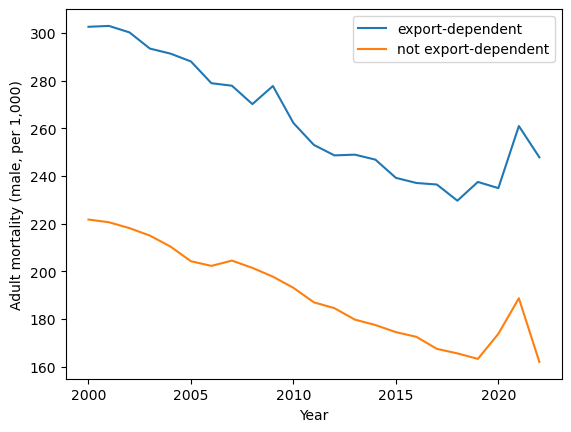

In [36]:
import matplotlib.pyplot as plt

tmp = panel.dropna(subset=["adult_mortality_male", "ag_export_share"]).copy()
tmp["group"] = tmp["export_dependent"].map({True: "export-dependent", False: "not export-dependent"})

trend = tmp.groupby(["year", "group"])["adult_mortality_male"].mean().reset_index()

for g in trend["group"].unique():
    sub = trend[trend["group"] == g]
    plt.plot(sub["year"], sub["adult_mortality_male"], label=g)

plt.xlabel("Year")
plt.ylabel("Adult mortality (male, per 1,000)")
plt.legend()
plt.show()

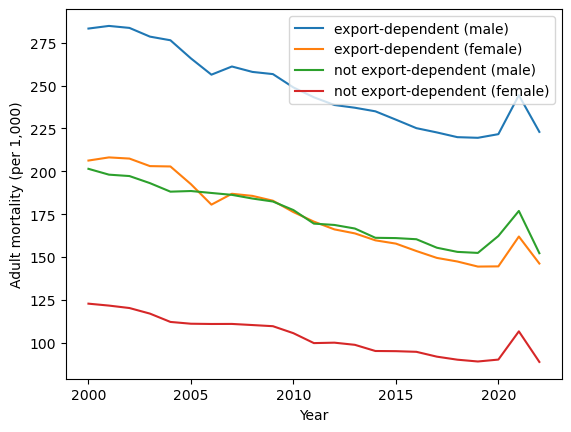

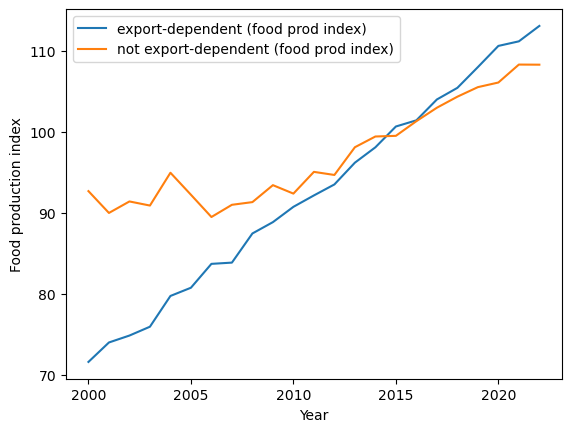

(adult_mortality_female    0.003005
 adult_mortality_male      0.003005
 food_prod_index           0.108595
 ag_export_share           0.228010
 dtype: float64,
     year                 group  n_obs
 0   2000      export-dependent     81
 1   2000  not export-dependent     79
 2   2001      export-dependent     77
 3   2001  not export-dependent     81
 4   2002      export-dependent     78
 5   2002  not export-dependent     83
 6   2003      export-dependent     80
 7   2003  not export-dependent     82
 8   2004      export-dependent     80
 9   2004  not export-dependent     81
 10  2005      export-dependent     79
 11  2005  not export-dependent     82,
    year                 group  adult_mortality_male  adult_mortality_female
 0  2000      export-dependent            283.287123              206.291840
 1  2000  not export-dependent            201.462835              122.809139
 2  2001      export-dependent            284.822844              208.126974
 3  2001  not export-de

In [37]:
df = fetch_wb_data(
    INDICATORS,
    start_year=2000,
    end_year=2022,
    cache_path="../data/wb_cache_countries.csv"
)

panel = build_panel(df)

cols_check = ["ag_export_share","food_prod_index","adult_mortality_male","adult_mortality_female"]
missing_rates = panel[cols_check].isna().mean().sort_values()

tmp_for_label = panel.dropna(subset=["ag_export_share"]).copy()
country_avg_export = tmp_for_label.groupby("country")["ag_export_share"].mean()
threshold = country_avg_export.median()
panel["export_dependent_country"] = panel["country"].map(country_avg_export >= threshold)

tmp = panel.dropna(subset=["ag_export_share","food_prod_index","adult_mortality_male","adult_mortality_female","export_dependent_country"]).copy()
tmp["group"] = tmp["export_dependent_country"].map({True: "export-dependent", False: "not export-dependent"})

trend_mort = (tmp.groupby(["year","group"])[["adult_mortality_male","adult_mortality_female"]]
              .mean()
              .reset_index()
              .sort_values(["year","group"]))

trend_food = (tmp.groupby(["year","group"])[["food_prod_index","ag_export_share"]]
              .mean()
              .reset_index()
              .sort_values(["year","group"]))

n_obs = (tmp.groupby(["year","group"])
         .size()
         .reset_index(name="n_obs")
         .sort_values(["year","group"]))

fig1 = plt.figure()
for g in trend_mort["group"].unique():
    sub = trend_mort[trend_mort["group"] == g]
    plt.plot(sub["year"], sub["adult_mortality_male"], label=f"{g} (male)")
    plt.plot(sub["year"], sub["adult_mortality_female"], label=f"{g} (female)")
plt.xlabel("Year")
plt.ylabel("Adult mortality (per 1,000)")
plt.legend()
plt.show()

fig2 = plt.figure()
for g in trend_food["group"].unique():
    sub = trend_food[trend_food["group"] == g]
    plt.plot(sub["year"], sub["food_prod_index"], label=f"{g} (food prod index)")
plt.xlabel("Year")
plt.ylabel("Food production index")
plt.legend()
plt.show()

missing_rates, n_obs.head(12), trend_mort.head(10), trend_food.head(10)

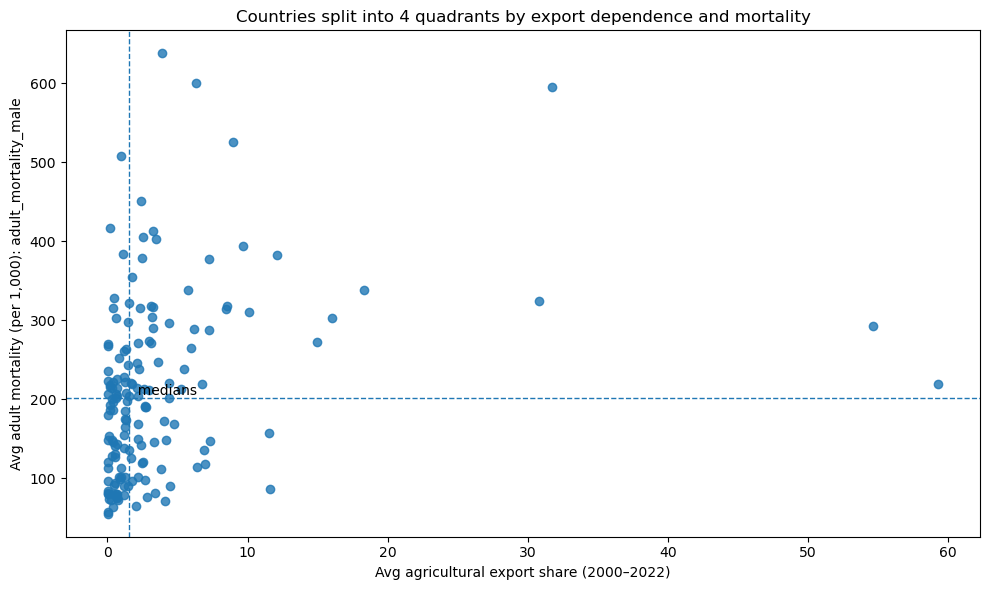

,country,avg_ag_export_share,avg_food_prod_index,avg_mortality,n_years,quadrant
149,Solomon Islands,59.326758,108.984706,219.186000,17,High export / High mort
17,Benin,54.670174,86.657826,292.027478,23,High export / High mort
31,Central African Republic,31.707963,91.843478,595.247304,23,High export / High mort
25,Burkina Faso,30.838805,84.365455,324.154045,22,High export / High mort
29,Cameroon,18.283218,80.301739,337.946913,23,High export / High mort
104,Mali,16.054720,85.315263,302.738211,19,High export / High mort
92,Latvia,14.970820,83.869130,271.879391,23,High export / High mort
86,Kenya,12.122866,91.132500,382.198100,20,High export / High mort
165,Togo,10.131911,93.210000,309.777682,22,High export / High mort
39,Cote d'Ivoire,9.695926,88.777826,394.219696,23,High export / High mort


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mort_col = "adult_mortality_male"
need = ["country", "ag_export_share", "food_prod_index", mort_col]

d = panel.dropna(subset=need).copy()

country_avg = (
    d.groupby("country")
     .agg(
         avg_ag_export_share=("ag_export_share", "mean"),
         avg_food_prod_index=("food_prod_index", "mean"),
         avg_mortality=(mort_col, "mean"),
         n_years=("year", "nunique")
     )
     .reset_index()
)

country_avg = country_avg[country_avg["n_years"] >= 15].copy()

x = country_avg["avg_ag_export_share"]
y = country_avg["avg_mortality"]

x_med = x.median()
y_med = y.median()

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x, y, alpha=0.8)

ax.axvline(x_med, linestyle="--", linewidth=1)
ax.axhline(y_med, linestyle="--", linewidth=1)

ax.set_xlabel("Avg agricultural export share (2000–2022)")
ax.set_ylabel(f"Avg adult mortality (per 1,000): {mort_col}")
ax.set_title("Countries split into 4 quadrants by export dependence and mortality")

ax.text(x_med, y_med, "  medians", va="bottom")

plt.tight_layout()
plt.show()

country_avg.assign(
    quadrant=np.select(
        [
            (x >= x_med) & (y >= y_med),
            (x >= x_med) & (y <  y_med),
            (x <  x_med) & (y >= y_med),
            (x <  x_med) & (y <  y_med),
        ],
        ["High export / High mort", "High export / Low mort", "Low export / High mort", "Low export / Low mort"],
        default="?"
    )
).sort_values(["quadrant","avg_ag_export_share"], ascending=[True, False]).head(20)

